In [3]:

import pandas as pd

df = pd.read_csv(r"C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\data\Nozzle2\Nozzle2_test_data.csv")

test_point = 35
fps = 25000
# px_mm_scale = df["px2mm_scale"][0] #To be calibrated later
px_mm_scale = 0.24
hydraulic_delay = 16


dataset = "median" # or "median"
USE_STD_WEIGHTS = False


In [4]:
df.shape[0]/50



65.0

In [5]:
df.columns

Index(['Unnamed: 0', 'penetration_average', 'penetration_median',
       'penetration_std', 'frame_number', 'time_us', 'chamber_pressure',
       'injection_pressure', 'injection_duration', 'tilt_angle', 'px2mm_scale',
       'plumes', 'diamter'],
      dtype='object')

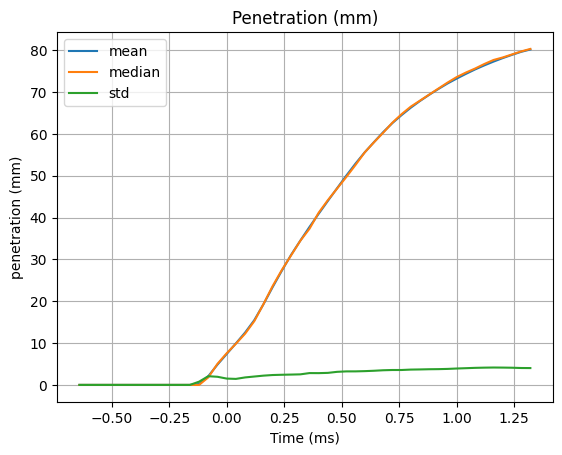

In [6]:
import matplotlib.pyplot as plt


df_tp = df[(test_point-1)*50:(test_point)*50]

plt.plot(1e3/fps*(df_tp["frame_number"]-hydraulic_delay), px_mm_scale*df_tp["penetration_average"], label = "mean")
plt.plot(1e3/fps*(df_tp["frame_number"]-hydraulic_delay), px_mm_scale*df_tp["penetration_median"], label="median")
plt.plot(1e3/fps*(df_tp["frame_number"]-hydraulic_delay), px_mm_scale*df_tp["penetration_std"], label="std")

plt.xlabel("Time (ms)")
plt.ylabel("penetration (mm)")
plt.title("Penetration (mm)")
plt.grid()
plt.legend()


In [7]:
# Physics informed neural network, part of loss function implementation

import torch 
import torch.nn as nn

class SprayPhysics(nn.Module):
    def __init__(
        self,
        *,
        init_params: dict[str, float],
        min_tau: float = 1e-4,
        eps: float = 1e-6,
    ) -> None:
        super().__init__()
        self.log_kv = nn.Parameter(
            torch.log(torch.tensor(init_params.get("kv", 1.0), dtype=torch.float32))
        )
        self.log_kp = nn.Parameter(
            torch.log(torch.tensor(init_params.get("kp", 1.0), dtype=torch.float32))
        )
        self.log_tau = nn.Parameter(
            torch.log(torch.tensor(init_params.get("tau", 0.1), dtype=torch.float32))
        )
        self.min_tau = float(min_tau)
        self.register_buffer("eps", torch.tensor(eps, dtype=torch.float32))

    def forward(self, inputs: dict[str, torch.Tensor]) -> torch.Tensor:
        t = torch.clamp(inputs["time"], min=self.eps)
        delta_p = torch.clamp(inputs.get("delta_p", torch.ones_like(t)), min=self.eps)
        rho_f = torch.clamp(inputs.get("rho_f", torch.ones_like(t)), min=self.eps)
        rho_a = torch.clamp(inputs.get("rho_a", torch.ones_like(t)), min=self.eps)
        diameter = torch.clamp(inputs.get("diameter", torch.ones_like(t)), min=self.eps)

        kv = torch.exp(self.log_kv)
        kp = torch.exp(self.log_kp)
        tau = torch.exp(self.log_tau) + self.min_tau

        linear_segment = kv * torch.sqrt(2.0 * delta_p / rho_f) * t
        sqrt_segment = (
            kp * torch.pow(delta_p / rho_a, 0.25) * torch.sqrt(diameter) * torch.sqrt(t)
        )

        weight = torch.exp(-t / tau)
        return weight * linear_segment + (1.0 - weight) * sqrt_segment

    def export_parameters(self) -> dict[str, float]:
        with torch.no_grad():
            return {
                "kv": float(torch.exp(self.log_kv).detach().cpu()),
                "kp": float(torch.exp(self.log_kp).detach().cpu()),
                "tau": float(torch.exp(self.log_tau).detach().cpu() + self.min_tau),
            }


In [8]:
import numpy as np



P_chamber = np.mean(df_tp["chamber_pressure"])* 1e5 # unit: Pa
P_injector = np.mean(df_tp["injection_pressure"]) * 1e5 # unit: Pa
delta_P = P_injector - P_chamber # unit: Pa

# diameter
d = np.mean(df_tp["diamter"]) * 1e-3 # unit: m

# Diesel properties
rho_diesel = 0.835*1e3 # 0.81~0.86 kg/L, unit: kg/m3

# Take air at 300K 
T = 300.0 # unit: K
R = 287.05 # unit J/(kg*K)
rho_air = P_chamber / R / T # unit: kg/m3


Hiroyasu & Arai: Two formulae as asymptotes, using fitted weights for their linear combinations.

$$
S(t) = w(t) \cdot k_v \sqrt{
\frac{2\Delta P}{
\rho_f}}\, t
+ (1-w(t)) \cdot k_p \left(
\frac{\Delta P}{
\rho_a}
\right)^{1/4} \sqrt{d}\, \sqrt{t}
$$

$$
w(t) = e^{-t/\tau}
$$

Fit: $$ \tau ,\ ln(k_v) ,\ ln(k_p) \ -> w(t), \ k_v, \ k_p $$

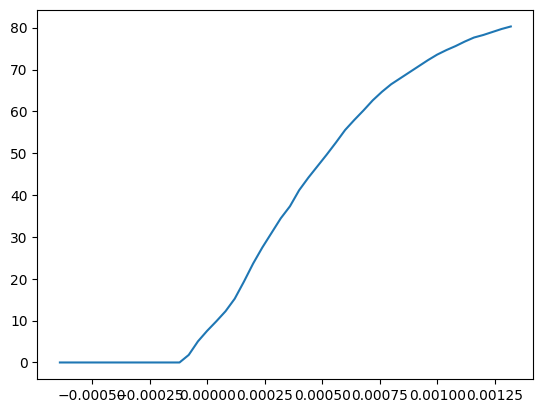

In [9]:
t = 1.0/fps*(df_tp["frame_number"].to_numpy(dtype=float)-hydraulic_delay)
if dataset== "median":    
    y = px_mm_scale * df_tp["penetration_median"].to_numpy(dtype=float)
elif dataset == "mean":
    y = px_mm_scale * df_tp["penetration_average"].to_numpy(dtype=float) # Use mean if needed

# weights from std (optional but recommended)
if "penetration_std" in df.columns and USE_STD_WEIGHTS:
    sigma = df_tp["penetration_std"].to_numpy(dtype=float)
    sigma = np.where(np.isfinite(sigma) & (sigma > 1e-9), sigma, np.nanmedian(sigma[np.isfinite(sigma) & (sigma > 0)]) )
else:
    sigma = np.ones_like(y)

plt.plot(t, y)



In [10]:
# Explicit model for Hiroyasu & Arai

def spary_penetration_model(params, t, delta_p, rho_f, rho_a, d):
    # params are in log-space to enforce positivity
    # (same spirit as in nn.Module)
    log_kv, log_kp, log_tau = params
    kv = np.exp(log_kv)
    kp = np.exp(log_kp)
    tau = np.exp(log_tau) + 1e-4 # min_tau

    t = np.clip(t, 1e-9, None)
    delta_p = np.clip(delta_p, 1e-12, None)
    rho_f = np.clip(rho_f, 1e-12, None)
    rho_a = np.clip(rho_a, 1e-12, None)
    d = np.clip(d, 1e-12, None)

    # Linear region asymptote
    linear = kv * np.sqrt(2.0 * delta_p / rho_f) * t

    # Sqrt region asymptote
    sqrt_segment = kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) * np.sqrt(t)

    w = np.exp(-t / tau)

    # Linear combination of linear and sqrt aymptotes to ensure differentiable function
    return w * linear + (1.0 - w) * sqrt_segment


def spary_penetration_model_d1(params, t, delta_p, rho_f, rho_a, d):
    # First derivative dS/dt for monotonic penalty.
    log_kv, log_kp, log_tau = params
    kv = np.exp(log_kv)
    kp = np.exp(log_kp)
    tau = np.exp(log_tau) + 1e-4 # min_tau

    t = np.clip(t, 1e-9, None)
    delta_p = np.clip(delta_p, 1e-12, None)
    rho_f = np.clip(rho_f, 1e-12, None)
    rho_a = np.clip(rho_a, 1e-12, None)
    d = np.clip(d, 1e-12, None)

    linear = kv * np.sqrt(2.0 * delta_p / rho_f) * t
    sqrt_segment = kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) * np.sqrt(t)

    linear_d = kv * np.sqrt(2.0 * delta_p / rho_f)
    sqrt_d = 0.5 * kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) / np.sqrt(t)

    w = np.exp(-t / tau)
    w_d = -w / tau

    return w * linear_d + (1.0 - w) * sqrt_d + w_d * (linear - sqrt_segment)


In [11]:
MONO_WEIGHT = 10.0

def residuals(params):
    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(valid):
        return np.array([1e6], dtype=float)

    t_fit = t[valid]
    y_fit = y[valid]
    sigma_fit = sigma[valid]

    y_hat = spary_penetration_model(params, t_fit, delta_P, rho_diesel, rho_air, d)
    r = (y_hat - y_fit) / sigma_fit

    if MONO_WEIGHT > 0:
        t_mono = t_fit[t_fit > 0]
        if t_mono.size:
            d1 = spary_penetration_model_d1(params, t_mono, delta_P, rho_diesel, rho_air, d)
            neg = np.minimum(d1, 0.0)
            r = np.concatenate([r, MONO_WEIGHT * neg])

    return r


In [12]:
from scipy.optimize import least_squares
# -----------------------------
# 3) 拟合（least_squares）
# -----------------------------
# 初值：你可以从经验常数或随便给一个数量级


init = {
    "kv": 1.0,
    "kp": 1.0,
    "tau": 1e-3,  # 1 ms 级别先试
}
x0 = np.log([init["kv"], init["kp"], init["tau"]])

res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)

log_kv, log_kp, log_tau = res.x
kv = float(np.exp(log_kv))
kp = float(np.exp(log_kp))
tau = float(np.exp(log_tau) + 1e-4)

print("Fit done.")
print(f"kv={kv:.6g}, kp={kp:.6g}, tau={tau:.6g} s")
print("cost:", res.cost, "success:", res.success)

Fit done.
kv=189.6, kp=4.82613e-05, tau=0.00173145 s
cost: 21.085296719886905 success: True


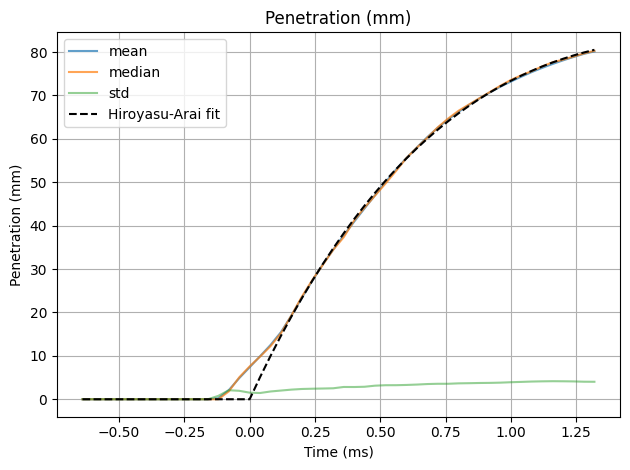

In [13]:
import matplotlib.pyplot as plt
t_ms = 1e3/fps * (df_tp["frame_number"] - hydraulic_delay)
t_s  = t_ms.to_numpy(dtype=float) * 1e-3  # ms -> s
t_ms_np = t_ms.to_numpy(dtype=float)


plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_average"],
    label="mean",
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_median"],
    label="median",
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_std"],
    label="std",
    alpha=0.5
)

# Plot fitted curve using seconds (model expects SI units), x-axis stays in ms.
plt.plot(
    t_ms_np,
    spary_penetration_model([log_kv, log_kp, log_tau], t_s, delta_P, rho_diesel, rho_air, d),
    "k--",
    linewidth=1.5,
    label="Hiroyasu-Arai fit"
)


plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.title("Penetration (mm)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


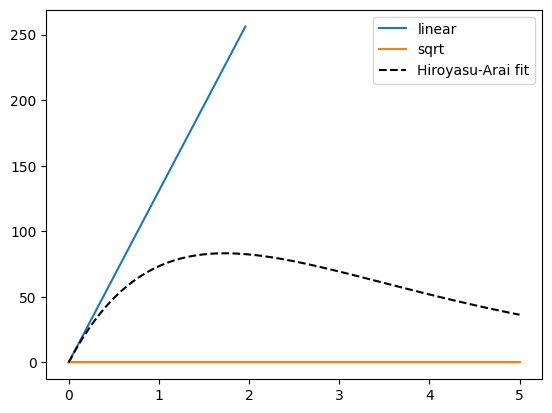

In [14]:
# Extrapolation

# 40us per frame, let us extrapolate to arond 5ms (5000us)
# 5000 / 40 = 125 frames

frames = 125
frame_n = np.linspace(0, frames, frames+1)
t_s  = 1/fps*frame_n
t_ms_np = 1e3* t_s

plt.plot(
    t_ms_np[:len(df_tp)],
    kv * np.sqrt(2.0 * delta_P / rho_diesel) *t_s[:len(df_tp)],
    label="linear"
)

plt.plot(
    t_ms_np,
    kp * np.power(delta_P / rho_air, 0.25) * np.sqrt(d) * np.sqrt(t_s),
    label="sqrt"
)

plt.plot(
    t_ms_np,
    spary_penetration_model([log_kv, log_kp, log_tau], t_s, delta_P, rho_diesel, rho_air, d),
    "k--",
    linewidth=1.5,
    label="Hiroyasu-Arai fit"
)

plt.legend()

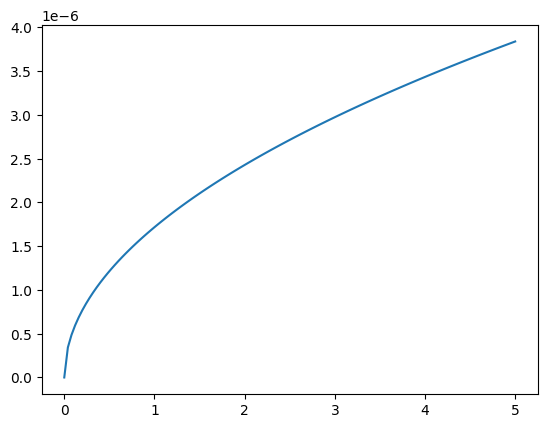

In [15]:
plt.plot(
    t_ms_np,
    kp * np.power(delta_P / rho_air, 0.25) * np.sqrt(d) * np.sqrt(t_s),
    label="sqrt"
)

Text(0.5, 1.0, '')

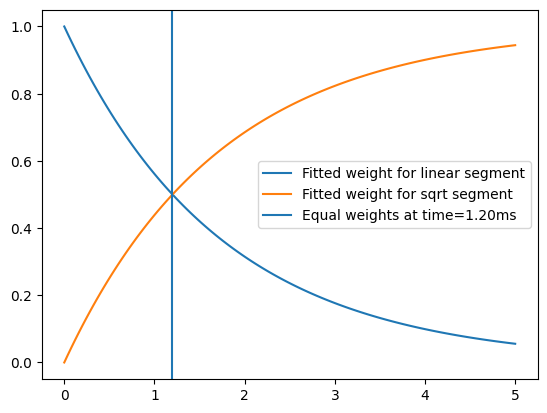

In [16]:
plt.plot(
    t_ms_np,
    np.exp(-t_s / tau),
    label="Fitted weight for linear segment"
)

plt.plot(
    t_ms_np,
    1 - np.exp(-t_s / tau),
    label="Fitted weight for sqrt segment"
)

t_s_half = - tau * np.log(0.5)

plt.axvline(t_s_half*1e3, label=f"Equal weights at time={t_s_half*1e3:.2f}ms")
plt.legend()
plt.title("")

Hiroyasu & Arai, two-segment formula plottings from Johnny's paper:

$$
t_b = K_{bt} \frac{\rho_f d_n}{\sqrt{(\rho_a \Delta P_{steady})}},\ K_{bt} = 28.65
$$

In [17]:
K_bt = 28.65
Kv_emperical = 0.25
Kp_empirical = 1.89


t_b =K_bt* rho_diesel*d/(np.sqrt(rho_air * delta_P))

t_b 


np.float64(0.00015256534217153176)

Linear Segment: $0 < t < t_b$

$$
S_{tip}(t) = K_v \sqrt{\frac{2\Delta P_{steady}}{\rho_f}} t, \ K_v = 0.39
$$

In [18]:


def linear_segment(t: np.ndarray)-> np.ndarray:
    return Kv_emperical * (2* delta_P / rho_diesel)**0.5 * t

Sqrt Segment: $t_b < t$

$$
S_{tip}(t) = K_p \left(
\frac{\Delta P}{
\rho_a}
\right)^{1/4} \sqrt{d}\, \sqrt{t},\ K_p = 2.95
$$

In [19]:


def sqrt_segment(t: np.ndarray) -> np.ndarray:
    return Kp_empirical* (delta_P/rho_air) ** 0.25 * np.sqrt(d) * np.sqrt(t) 

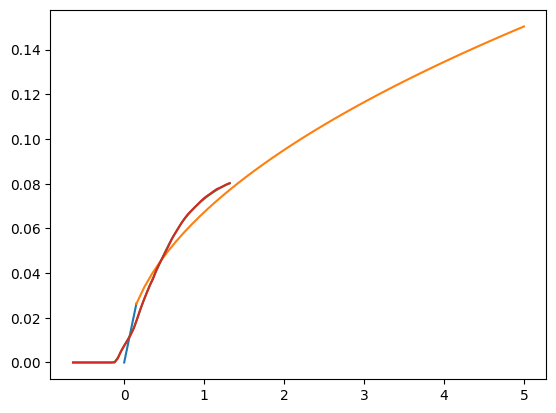

In [20]:
samples = 20
zero2tb = np.linspace(0, t_b, samples)
tb2uplim = np.linspace(t_b, 1/fps*frames)

plt.plot(zero2tb*1e3, linear_segment(zero2tb))

plt.plot(tb2uplim*1e3, sqrt_segment(tb2uplim))
t_ms = 1e3/fps*(df_tp["frame_number"]-hydraulic_delay)
plt.plot(t_ms, 1e-3*px_mm_scale*df_tp["penetration_average"], label = "mean")
plt.plot(t_ms, 1e-3*px_mm_scale*df_tp["penetration_median"], label="median")
# plt.plot(1e3/fps*(df_tp["frame_number"]-hydraulic_delay), 1e-3*px_mm_scale*df_tp["penetration_std"], label="std")




Hiroyasu & Arai: Two formulae as asymptotes, using fitted weights for their linear combinations.

$$
S(t) = w(t) \cdot k_v \sqrt{
\frac{2\Delta P}{
\rho_f}}\, t
+ (1-w(t)) \cdot k_p \left(
\frac{\Delta P}{
\rho_a}
\right)^{1/4} \sqrt{d}\, \sqrt{t}
$$

Here, we use:

$$
w(t) = \sigma (\frac{t_b-t}{s}) = \frac{1}{1+e^{\frac{t_b-t}{s}}}
$$

Fit: $$ t_b, s ,\ ln(k_v) ,\ ln(k_p) \ -> w(t), \ k_v, \ k_p $$

In [21]:
# Explicit model for Hiroyasu & Arai

from scipy.special import expit  # expit(x) = 1 / (1 + exp(-x))

min_tb = 1e-4

def spary_penetration_model_sigmoid(params, t, delta_p, rho_f, rho_a, d):
    # params are in log-space to enforce positivity
    # (same spirit as in nn.Module)
    log_kv, log_kp, log_tb, log_s = params
    kv = np.exp(log_kv)
    kp = np.exp(log_kp)
    tb = np.exp(log_tb) + min_tb # min_tb
    s = np.exp(log_s)


    t = np.clip(t, 1e-9, None)
    delta_p = np.clip(delta_p, 1e-12, None)
    rho_f = np.clip(rho_f, 1e-12, None)
    rho_a = np.clip(rho_a, 1e-12, None)
    d = np.clip(d, 1e-12, None)

    # Linear region asymptote
    linear = kv * np.sqrt(2.0 * delta_p / rho_f) * t

    # Sqrt region asymptote
    sqrt_segment = kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) * np.sqrt(t)

    # Sigmoid function of changing weights
    # w = 1.0 / ( 1+ np.exp((tb-t)/s))
    w = expit((t - tb) / s)

    # Linear combination of linear and sqrt aymptotes to ensure differentiable function
    return (1.0 - w) * linear + w * sqrt_segment

'''
def spary_penetration_model_d1(params, t, delta_p, rho_f, rho_a, d):
    # First derivative dS/dt for monotonic penalty.
    log_kv, log_kp, log_tau = params
    kv = np.exp(log_kv)
    kp = np.exp(log_kp)
    tau = np.exp(log_tau) + 1e-4 # min_tau

    t = np.clip(t, 1e-9, None)
    delta_p = np.clip(delta_p, 1e-12, None)
    rho_f = np.clip(rho_f, 1e-12, None)
    rho_a = np.clip(rho_a, 1e-12, None)
    d = np.clip(d, 1e-12, None)

    linear = kv * np.sqrt(2.0 * delta_p / rho_f) * t
    sqrt_segment = kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) * np.sqrt(t)

    linear_d = kv * np.sqrt(2.0 * delta_p / rho_f)
    sqrt_d = 0.5 * kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) / np.sqrt(t)

    w = np.exp(-t / tau)
    w_d = -w / tau

    return w * linear_d + (1.0 - w) * sqrt_d + w_d * (linear - sqrt_segment)
'''

'\ndef spary_penetration_model_d1(params, t, delta_p, rho_f, rho_a, d):\n    # First derivative dS/dt for monotonic penalty.\n    log_kv, log_kp, log_tau = params\n    kv = np.exp(log_kv)\n    kp = np.exp(log_kp)\n    tau = np.exp(log_tau) + 1e-4 # min_tau\n\n    t = np.clip(t, 1e-9, None)\n    delta_p = np.clip(delta_p, 1e-12, None)\n    rho_f = np.clip(rho_f, 1e-12, None)\n    rho_a = np.clip(rho_a, 1e-12, None)\n    d = np.clip(d, 1e-12, None)\n\n    linear = kv * np.sqrt(2.0 * delta_p / rho_f) * t\n    sqrt_segment = kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) * np.sqrt(t)\n\n    linear_d = kv * np.sqrt(2.0 * delta_p / rho_f)\n    sqrt_d = 0.5 * kp * np.power(delta_p / rho_a, 0.25) * np.sqrt(d) / np.sqrt(t)\n\n    w = np.exp(-t / tau)\n    w_d = -w / tau\n\n    return w * linear_d + (1.0 - w) * sqrt_d + w_d * (linear - sqrt_segment)\n'

In [22]:
# MONO_WEIGHT = 10.0

def residuals_sigmoid(params):
    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(valid):
        return np.array([1e6], dtype=float)

    t_fit = t[valid]
    y_fit = y[valid]
    sigma_fit = sigma[valid]

    y_hat = spary_penetration_model_sigmoid(params, t_fit, delta_P, rho_diesel, rho_air, d)
    r = (y_hat - y_fit) / sigma_fit
    '''
    if MONO_WEIGHT > 0:
        t_mono = t_fit[t_fit > 0]
        if t_mono.size:
            d1 = spary_penetration_model_d1(params, t_mono, delta_P, rho_diesel, rho_air, d)
            neg = np.minimum(d1, 0.0)
            r = np.concatenate([r, MONO_WEIGHT * neg])
    '''
    return r


In [23]:
from scipy.optimize import least_squares
# -----------------------------
# 3) 拟合（least_squares）
# -----------------------------
# 初值：你可以从经验常数或随便给一个数量级


init = {
    "kv": 1.0,
    "kp": 1.0,
    # "tau": 1e-3,  # 1 ms 级别先试
    "tb": 1e-1,
    "s" : 1,

}
x0 = np.log([init["kv"], init["kp"], init["tb"], init["s"]])

res = least_squares(residuals_sigmoid, x0, method="trf", loss="huber", f_scale=1.0)

log_kv, log_kp, log_tb, log_s = res.x
kv = float(np.exp(log_kv))
kp = float(np.exp(log_kp))
tb= float(np.exp(log_tb) + min_tb ) 
s = float(np.exp(log_s))

print("Fit done.")
print(f"kv={kv:.6g}, kp={kp:.6g}, tb={1e3*tb:.3g} ms, s={s:.6g}")
print("cost:", res.cost, "success:", res.success)

Fit done.
kv=174.511, kp=1409.46, tb=0.591 ms, s=0.000588568
cost: 17.648785743951954 success: True


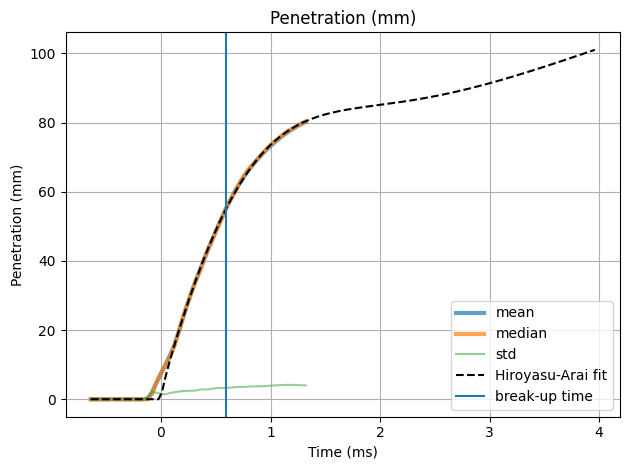

In [24]:
import matplotlib.pyplot as plt
t_ms = 1e3/fps * (df_tp["frame_number"] - hydraulic_delay)
t_s  = t_ms.to_numpy(dtype=float) * 1e-3  # ms -> s
t_ms_np = t_ms.to_numpy(dtype=float)

triple_ts = np.linspace(t_s[0], 3*t_s[-1], 3*len(t_s)) 


plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_average"],
    label="mean",
    linewidth=3,
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_median"],
    label="median",
    linewidth=3,
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_std"],
    label="std",
    
    alpha=0.5
)

# Plot fitted curve using seconds (model expects SI units), x-axis stays in ms.
plt.plot(
    triple_ts*1e3, 
    spary_penetration_model_sigmoid([log_kv, log_kp, log_tb, log_s], triple_ts, delta_P, rho_diesel, rho_air, d),
    "k--",
    linewidth=1.5,
    label="Hiroyasu-Arai fit"
)


plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.title("Penetration (mm)")
plt.axvline(1e3*tb, label="break-up time")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



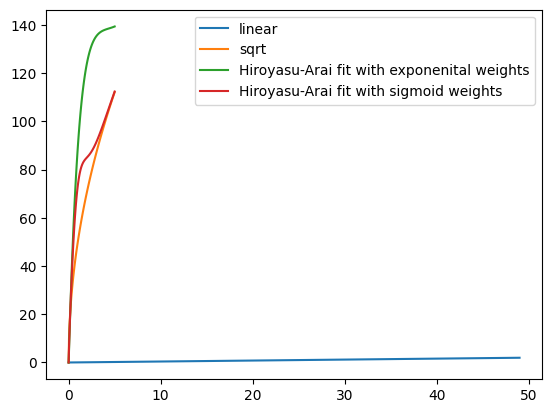

In [25]:
# Extrapolation

# 40us per frame, let us extrapolate to arond 5ms (5000us)
# 5000 / 40 = 125 frames

frames = 125
frame_n = np.linspace(0, frames, frames+1)
t_s  = 1/fps*frame_n
t_ms_np = 1e3* t_s

plt.plot(
    t_ms_np[:len(df_tp)],
    # kv * np.sqrt(2.0 * delta_P / rho_diesel) *t_s[:len(df_tp)],

        
    label="linear"
)

plt.plot(
    t_ms_np,
    kp * np.power(delta_P / rho_air, 0.25) * np.sqrt(d) * np.sqrt(t_s),
    label="sqrt"
)

plt.plot(
    t_ms_np,
    spary_penetration_model([log_kv, log_kp, log_tau], t_s, delta_P, rho_diesel, rho_air, d),
    # "k--",
    linewidth=1.5,
    label="Hiroyasu-Arai fit with exponenital weights"
)

plt.plot(
    t_ms_np,
    spary_penetration_model_sigmoid([log_kv, log_kp, log_tb, log_s], t_s, delta_P, rho_diesel, rho_air, d),
    # "k--",
    linewidth=1.5,
    label="Hiroyasu-Arai fit with sigmoid weights"
)

plt.legend()

0.0005907186743326772

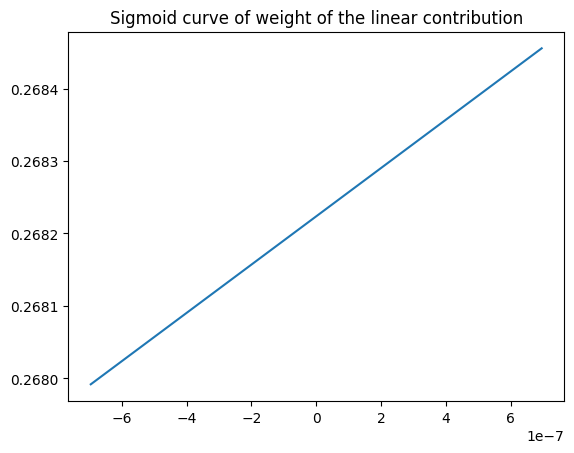

In [28]:
# Sigmoid function of changing weights
t_w = np.linspace(-2*s*tb, 2*s*tb, 1000)

w = expit((t_w - tb) / s)

plt.plot(t_w, w)

# plt.axvline(tb)

plt.title("Sigmoid curve of weight of the linear contribution")

tb